In [1]:
from graphviz import Digraph, Graph
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
from numpy import mean

from analysis import *
from joblib import Parallel, delayed

# base_dir = '/Users/dhruvlaad/IIT/DDP/data/'
base_dir = 'D:/IIT/DDP/data/'
label_info_file = base_dir + 'analysis/label_info.pkl'
stats_file = base_dir + 'analysis/stats.pkl'

In [2]:
behaviour_stats = all_behaviour_info_for_all_strains(label_info_file, max_label=19)

for key in BEHAVIOUR_LABELS.keys():
    nb_max = max(behaviour_stats[key]['No. of Bouts'])
    print(f'{key}: {nb_max}')
    
# with open(stats_file, 'rb') as f:
#     behaviour_stats = joblib.load(f)

Groom: 243
Run: 1988
Walk: 1291
CW-Turn: 843
CCW-Turn: 727
Point: 3131
Rear: 3222
N/A: 5171


In [33]:
# behaviour_stats.keys()
key = 'Point'
plot_dir = base_dir + 'analysis/plots'
stats = behaviour_stats[key]
info = pd.DataFrame.from_dict(stats)

In [34]:
info_ = info.copy(deep=True)
info_['Total Duration'] = info['Total Duration']/60
info_['Average Bout Length'] = info['Average Bout Length']

# plotting routines

In [35]:
def sort_info_df(info, metric):
    N = info.shape[0]
    strains = {}
    for strain in info['Strain']:
        strains[strain] = []
        
    for i in range(N):
        data = info.iloc[i]
        strains[data['Strain']].append(data[metric])
    
    for key, value in strains.items():
        strains[key] = sum(value)/len(value)
    
    strains = dict(sorted(strains.items(), key=lambda item: item[1]))
    return strains.keys()

def plot_behaviour_metric(info, metric, order, ylabel=None):        
    ylabel = metric if ylabel is None else ylabel
    
    fig = plt.figure(figsize=(10, 100))
    g = sns.catplot(x='Strain', y=metric, data=info, hue='Sex', jitter=False, legend=False, order=order, ci=0.95)
    ax = g.axes[0,0]
    ax.tick_params(grid_color='gray', grid_alpha=0.3, labelrotation=90, labelsize=8)
    ax.grid(True)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xlabel(None, fontsize=12)
    ax.legend(loc='upper left')
    plt.gcf().set_size_inches(15, 2.2)
    return fig, ax

<Figure size 720x7200 with 0 Axes>

<Figure size 720x7200 with 0 Axes>

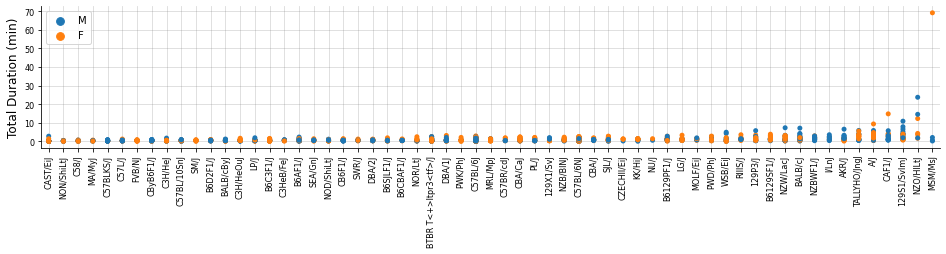

In [36]:
strains = list(sort_info_df(info_, 'Total Duration'))
fig, ax = plot_behaviour_metric(info_, 'Total Duration', strains, 'Total Duration (min)', )
ax.tick_params(axis='y', labelrotation=0, labelsize=8)
fig

<Figure size 720x7200 with 0 Axes>

<Figure size 720x7200 with 0 Axes>

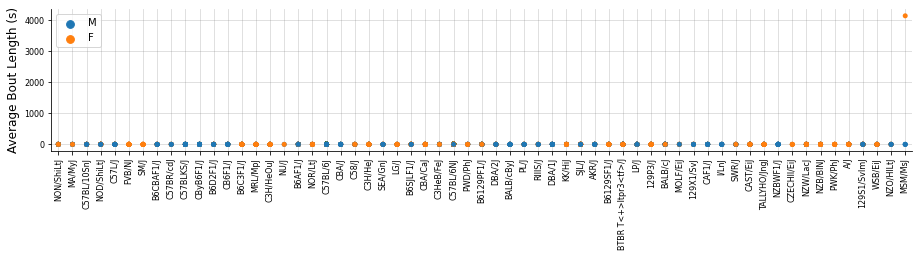

In [39]:
strains = list(sort_info_df(info_, 'Average Bout Length'))
fig, ax = plot_behaviour_metric(info_, 'Average Bout Length', strains, 'Average Bout Length (s)', )
# ax.set_ylim([MIN_BOUT_LENS[key]/1000, 2])
ax.tick_params(axis='y', labelrotation=0, labelsize=8)
fig

<Figure size 720x7200 with 0 Axes>

<Figure size 720x7200 with 0 Axes>

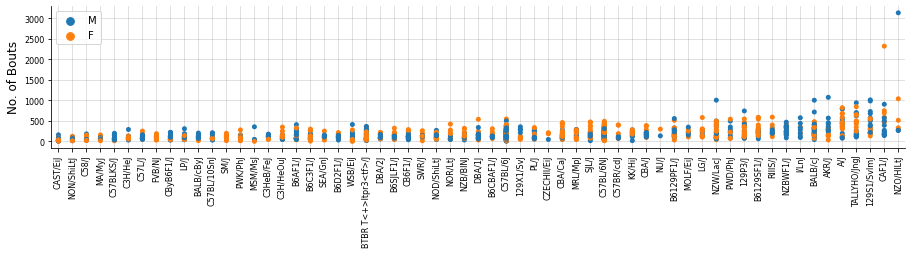

In [38]:
strains = list(sort_info_df(info_, 'No. of Bouts'))
fig, ax = plot_behaviour_metric(info_, 'No. of Bouts', strains, 'No. of Bouts', )
ax.tick_params(axis='y', labelrotation=0, labelsize=8)
fig

In [ ]:
# plot behaviour distribution for all data
import numpy as np
from analysis import *
from BSOID.bsoid import BSOID

prop = 100 * calculate_behaviour_usage(label_info_file, max_label=19)

labels = [None for _ in range(len(prop))]
for key, val in BEHAVIOUR_LABELS.items():
    if len(val) > 1:
        for i, idx in enumerate(val):
            labels[idx] = f'{key} #{i}'
    else:
        labels[val[0]] = key
fig = plt.figure(figsize=(12,9))
ax = sns.barplot(x=np.arange(len(prop)), y=prop)
ax.set_xticklabels(labels)
ax.set_ylabel('% samples of behaviour')
ax.tick_params(axis='x', labelrotation=90, labelsize=12)
fig.savefig(f'{plot_dir}/prop.png')
fig.show()

# Show proportion of behaviour used for each strain
----

In [ ]:
usage_data = behaviour_usage_across_strains(stats_file, min_threshold=0.01)
usage_data = usage_data.pivot_table(index='Behaviour', columns='Strain', values='Usage')

ax = sns.heatmap(usage_data, xticklabels=True, yticklabels=True, cmap='cubehelix')
plt.gcf().set_size_inches(15.5, 4)
plt.savefig(f'{plot_dir}/usage.png')
plt.show() 

# Plot transition network

In [111]:
def tnet_from_tmat(tmat, behaviour_usage, n_grps):
    from sklearn.cluster import SpectralClustering
    node_groups = SpectralClustering(n_clusters=n_grps, affinity='precomputed').fit_predict(tmat)
    
    graph_attr = {'size':'5,5!', 'dpi':'200', 'overlap':'false', 'splines':'false'}
    G = Graph(format='png', engine='neato', graph_attr=graph_attr)
    
    groups = [[] for i in range(n_grps)]
    for i in range(len(behaviour_usage)):
        groups[node_groups[i]].append([i, behaviour_usage[i]])
    for g in groups:
        g.sort(reverse=True, key=lambda x:x[1])
    groups.sort(reverse=True, key=lambda x:x[0][1])

    for i, g in enumerate(groups):
        for node in g:
            G.node(name=str(g[0]), 
                   label='', 
                   group=str(i), 
                   width=str(g[1]), 
                   height=str(g[1])
                )
    
    from itertools import permutations
    for g in groups:
        for i, j in permutations(range(len(g)), 2):
            node1, node2 = g[i], g[j]
            G.edge(str(node1[0]), str(node2[0]), constraint='false')
    
    return G
        
def get_usage_for_strain(label_info_file, strain=None, max_label=None):
    with open(label_info_file, 'rb') as f:
        label_info = joblib.load(f)
    N = len(label_info['Strain'])
    
    if strain is not None:
        labels = [label_info['Labels'][i] for i in range(N) if label_info['Strain'][i] == strain]
    else:
        labels = label_info['Labels']
    del label_info
    
    usage_data = Parallel(n_jobs=-1)(delayed(behaviour_proportion)(labs, max_label) for labs in labels)
#     usage_data = np.vstack([behaviour_proportion(labs, max_label) for labs in labels])
    usage_data = np.vstack(usage_data)
    usage_data = usage_data.sum(axis=0)/usage_data.shape[0]
    return usage_data
    
def get_tmat_for_strain(label_info_file, strain=None, max_label=None):
    with open(label_info_file, 'rb') as f:
        label_info = joblib.load(f)
    N = len(label_info['Strain'])
    
    if strain is not None:
        labels = [label_info['Labels'][i] for i in range(N) if label_info['Strain'][i] == strain]
    else:
        labels = label_info['Labels']
    del label_info
    
#     tmat_data = [transition_matrix_from_assay(labs, max_label) for labs in labels]
    tmat_data = Parallel(n_jobs=-1)(delayed(transition_matrix_from_assay)(labs, max_label) for labs in labels)
            
    tmat = tmat_data[0]
    for i in range(1, len(tmat_data)):
        tmat += tmat_data[i]
    
    tmat = tmat / len(tmat_data)
    return tmat

In [92]:
tmat = get_tmat_for_strain(label_info_file, max_label=19)
usage = get_usage_for_strain(label_info_file, max_label=19)

In [112]:
G = tnet_from_tmat(tmat, usage, 4)
G.view()

C:\Users\dhruvlaad\anaconda3\envs\ddp\lib\site-packages\sklearn\utils\validation.py:72: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(**kwargs)


'Graph.gv.png'

In [102]:
groups

[[[7, 0.17298924190730916],
  [3, 0.03803596493531124],
  [19, 0.010341313332939616],
  [17, 0.01015824169625263],
  [14, 0.0064991382742074924],
  [18, 0.005526540946738602],
  [16, 0.002631333652293207]],
 [[0, 0.16640431038100123],
  [11, 0.10557034064196208],
  [9, 0.049489744160724866],
  [13, 0.045301139676077774],
  [15, 0.04196229053534306],
  [12, 0.02241753229596494]],
 [[6, 0.08969884799899358],
  [8, 0.08343459627084612],
  [10, 0.06552015059504164]],
 [[1, 0.039216321918880866],
  [5, 0.02796791060246876],
  [2, 0.0121288999542733],
  [4, 0.004706140223369719]]]